# General 

## Python modules

In [60]:
!pip install transformers
!pip install sentencepiece
!pip install ipywidgets
!pip install simpletransformers
!pip install seaborn
!pip install sacremoses
!pip install googletrans==4.0.0-rc1
!pip install googledrivedownloader

from IPython.display import clear_output 
clear_output()

## Imports

In [61]:
from nltk.corpus import wordnet
import copy
import nltk
from sklearn.utils import resample

from urllib import request
import torch
from torch.utils.data import DataLoader, Dataset
import transformers
import torch.nn as nn
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import logging

from transformers import RobertaModel, RobertaTokenizer

import pandas as pd
import numpy as np
import os
import random
from pathlib import Path

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,mean_absolute_error, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from google_drive_downloader import GoogleDriveDownloader as gdd
from urllib import request

clear_output()

## Connect to device

In [62]:
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)


if not torch.cuda.is_available():
  print('WARNING: You may want to change the runtime to GPU for faster training!')
  DEVICE = 'cpu'
else:
  DEVICE = 'cuda:0'
print("Using "+ DEVICE)

# Setting the random seeds manually

random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

Using cuda:0


## Download DS & Labels

In [63]:
module_url_list = [
    "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv",
    "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv",
    "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv"
]

for module_url in module_url_list:
    module_name = module_url.split('/')[-1]    
    with request.urlopen(module_url) as f, open(module_name,'w') as outf:
        a = f.read()
        outf.write(a.decode('utf-8'))

gdd.download_file_from_google_drive(file_id='1rbwLNB2BOFrrPaaq4M7mrhXngEfoG7yH',
                                    dest_path='./dontpatronizeme_categories.tsv',
                                    unzip=False)
        
gdd.download_file_from_google_drive(file_id='152MgJAIqK4x_G1xJrZB9GRg5AkTocs7I',
                                    dest_path='./dontpatronizeme_pcl.tsv',
                                    unzip=False)

module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
    a = f.read()
    outf.write(a.decode('utf-8'))

module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py"
module_name = module_url.split('/')[-1]

with request.urlopen(module_url) as f, open(module_name,'w') as outf:
    a = f.read()
    outf.write(a.decode('utf-8'))
  
from dont_patronize_me import DontPatronizeMe

dpm_dir = "."
out_dir = "."

dpm = DontPatronizeMe(".", ".")

"""
dpm = DontPatronizeMe(".", "."): This line creates an instance of the DontPatronizeMe class,
with the current working directory as the input for both dpm_dir and out_dir arguments.
dpm_dir is the directory where the DPM dataset is located, and out_dir is the directory where the predictions will be saved
"""

dpm.load_task1()
dpm.load_task2(return_one_hot=True)

"""
dpm.load_task1(): This line loads the first task of the DPM dataset into the DontPatronizeMe instance. 
Task 1 is a binary classification task where the goal is to predict whether a given text contains patronizing language or not.

dpm.load_task2(return_one_hot=True): This line loads the second task of the DPM dataset into the DontPatronizeMe instance. 
Task 2 is a multi-label classification task where the goal is to predict which identities are targeted by patronizing language in a given text.
return_one_hot=True specifies that the labels should be returned in one-hot encoding format.
"""
None

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


# Functions for training the model

 ## Tokenizer

In [64]:
# Tokenizer used for a Roberta
tokenizer = RobertaTokenizer.from_pretrained('roberta-base',
                                             truncation=True,
                                             do_lower_case=True)

# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4

In [65]:
class DpmData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

# Dataset handling

## Get train_set and test_set

In [66]:
# Dataset has been downloaded already, now we have to retrieve it. Par is short for paragraph

trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)


# => For the Train Ids

rows = []
for idx in range(len(trids)):
    
    # Retrieve the training id 
    parid = trids.par_id[idx]

    # select row from original dataset to retrieve `text`, binary label and original label
    text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
    label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
    orig_label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].orig_label.values[0]
    
    # Construct row with desired features: id, text, binary label and original label
    rows.append({
      'par_id':parid,
      'text':text,
      'label':label,
        'orig_label':orig_label
    })
    
# Concatenate and transform to DF
train_set = pd.DataFrame(rows)  

# => For the Test Ids

rows = []
for idx in range(len(teids)):
    
    # Retrieve the testing id 
    parid = teids.par_id[idx]

    # select row from original dataset to retrieve `text`, binary label and original label
    text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
    label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
    orig_label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].orig_label.values[0]
    
    # Construct row with desired features: id, text, label and original label
    rows.append({
      'par_id':parid,
      'text':text,
      'label':label,
        'orig_label':orig_label
    })
    
# Concatenate and transform to DF    
test_set = pd.DataFrame(rows)
None

# Split into training and validation sets
train_set, val_set = train_test_split(train_set, test_size=0.2)


train_set = train_set.reset_index(drop=True)
val_set = val_set.reset_index(drop=True)

print(f"Train={len(train_set)}, Val={len(val_set)}, own Test={len(test_set)}\n\n")

train_set.head()

Train=6700, Val=1675, own Test=2094




,par_id,text,label,orig_label
0,3737,NEW YORK -- New York officials and community a...,0,0
1,7710,Cheri Van Loon posted that ' smart men respect...,0,0
2,4415,"Nairobi , Kenya - After enduring months of gre...",0,0
3,9343,"""Lougene has this message to others who may st...",1,4
4,3922,""""""" The humanitarian architecture has not kept...",0,0


## Create final testing set

In [67]:
column_names = ['art_id', 'keyword', 'country', 'text']

# read the TSV file and specify the column names
real_test_set = pd.read_csv("task4_test.tsv", delimiter="\t", names=column_names)

real_test_set["label"] = 1

real_test_set.head()

,art_id,keyword,country,text,label
t_0,@@7258997,vulnerable,us,"In the meantime , conservatives are working to...",1
t_1,@@16397324,women,pk,In most poor households with no education chil...,1
t_2,@@16257812,migrant,ca,The real question is not whether immigration i...,1
t_3,@@3509652,migrant,gb,"In total , the country 's immigrant population...",1
t_4,@@477506,vulnerable,ca,"Members of the church , which is part of Ken C...",1


Here, we have our train_set, val_set, test_set and real_test_set Dataframe variables ready for down sampling and data augmentation. 'test_set' is from the dev dataset whereas the 'real_test_set' is from the task4 data set.

We will separate the augmented dataset from the non-augmented. Eventually we'll have 3 datasets:
- train_set
- val_set
- test_set
- augmented_train_set

## Data Augmentation

In [68]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download("omw")

augmented_train_set = train_set.copy()

# Filter the dataframe to only include the rows with orig_label 2 or 3
filtered_train_set = augmented_train_set[augmented_train_set['orig_label'].isin(["2", "3", "4"])].reset_index(drop=True)

# Define a function to perform synonym replacement
def synonym_replacement(sentence):
    words = sentence.split()
    new_sentence = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if len(synonyms) > 0:
            new_word = synonyms[0].lemmas()[0].name()  # Use the first synonym
            if new_word != word:
                new_sentence.append(new_word)
            else:
                new_sentence.append(word)
        else:
            new_sentence.append(word)
    return ' '.join(new_sentence)

# Define a function to perform random deletion
def random_deletion(sentence, p=0.5):
    words = sentence.split()
    new_sentence = []
    for word in words:
        if random.uniform(0, 1) < p:
            continue
        else:
            new_sentence.append(word)
    return ' '.join(new_sentence)

# Define a function to perform random swap
def random_swap(sentence, n=3):
    words = sentence.split()
    new_sentence = words.copy()
    for i in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        new_sentence[idx1], new_sentence[idx2] = new_sentence[idx2], new_sentence[idx1]
    return ' '.join(new_sentence)

# Apply the data augmentation techniques to the filtered dataset

augmented_data = filtered_train_set.copy()
augmented_data_1 = filtered_train_set.copy()
augmented_data_2 = filtered_train_set.copy()
augmented_data_3 = filtered_train_set.copy()

augmented_data_synonym = filtered_train_set.copy()
augmented_data_del = filtered_train_set.copy()
augmented_data_swap = filtered_train_set.copy()

####### augmented_data is augmented three ways #######

augmented_data_synonym['text'] = augmented_data['text'].apply(synonym_replacement)
augmented_data_del['text'] = augmented_data['text'].apply(random_deletion)
#augmented_data_swap['text'] = augmented_data['text'].apply(random_swap)


# concatenate the original training data with the augmented data generated by each technique
augmented_data_1_aux = augmented_data_synonym.sample(frac=0.6).reset_index(drop=True)
augmented_data_2_aux = augmented_data_del.sample(frac=0.4).reset_index(drop=True)
#augmented_data_3_aux = augmented_data_swap.sample(frac=0.4).reset_index(drop=True) # Not useful

concatenated_data = pd.concat([
    filtered_train_set.sample(frac=0.7),
    augmented_data_1_aux,
    augmented_data_2_aux,
#    augmented_data_3_aux
], ignore_index=True)

# shuffle the concatenated data
augmented_data = concatenated_data.sample(frac=1).reset_index(drop=True)

print("\nNo. of added examples for full Data Augmentation:             ", len(augmented_data)-len(filtered_train_set))


####### augmented_data_1 is augmented via synonym ######

augmented_data_1['text'] = augmented_data_1['text'].apply(synonym_replacement)
augmented_data_1 = pd.concat([augmented_data_1, filtered_train_set.copy().sample(frac=0.6).reset_index(drop=True)])

print("No. of added examples for synonym Data Augmentation:          ", len(augmented_data_1)-len(filtered_train_set))

##### augmented_data_2 is augmented via random deletion ######

augmented_data_2['text'] = augmented_data_2['text'].apply(random_deletion)
augmented_data_2 = pd.concat([augmented_data_2, filtered_train_set.copy().sample(frac=0.6).reset_index(drop=True)])

print("No. of added examples for random deletion Data Augmentation:  ", len(augmented_data_2)-len(filtered_train_set))


####### augmented_data_3 is augmented via random swap ######

augmented_data_3['text'] = augmented_data_3['text'].apply(random_swap)
augmented_data_3 = pd.concat([augmented_data_3, filtered_train_set.copy().sample(frac=0.6).reset_index(drop=True)])

print("No. of added examples for random swap Data Augmentation:      ", len(augmented_data_3)-len(filtered_train_set))


# Concatenate the original train set with the augmented data

augmented_train_set_0 = pd.concat([augmented_train_set, augmented_data]).reset_index(drop=True)
augmented_train_set_1 = pd.concat([augmented_train_set, augmented_data_1]).reset_index(drop=True)
augmented_train_set_2 = pd.concat([augmented_train_set, augmented_data_2]).reset_index(drop=True)
augmented_train_set_3 = pd.concat([augmented_train_set, augmented_data_3]).reset_index(drop=True)

print(f"\nPreviously, we had about {len(train_set)} sentences, now we have {len(augmented_train_set_0)} sentences")
augmented_train_set.head()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Package omw is already up-to-date!



No. of added examples for full Data Augmentation:              454
No. of added examples for synonym Data Augmentation:           389
No. of added examples for random deletion Data Augmentation:   389
No. of added examples for random swap Data Augmentation:       389

Previously, we had about 6700 sentences, now we have 7802 sentences


,par_id,text,label,orig_label
0,3737,NEW YORK -- New York officials and community a...,0,0
1,7710,Cheri Van Loon posted that ' smart men respect...,0,0
2,4415,"Nairobi , Kenya - After enduring months of gre...",0,0
3,9343,"""Lougene has this message to others who may st...",1,4
4,3922,""""""" The humanitarian architecture has not kept...",0,0


**Recap of the elements BEFORE downsampling**

In [69]:
print(f"train_set contains {len(train_set)} sentences")
print(f"augmented_train_set_0 contains {len(augmented_train_set_0)} sentences")
print(f"augmented_train_set_1 contains {len(augmented_train_set_1)} sentences")
print(f"augmented_train_set_2 contains {len(augmented_train_set_2)} sentences")
print(f"augmented_train_set_3 contains {len(augmented_train_set_3)} sentences")

print("\nProportion before on the full DA dataset:", augmented_train_set_0.mean()["label"])

train_set contains 6700 sentences
augmented_train_set_0 contains 7802 sentences
augmented_train_set_1 contains 7737 sentences
augmented_train_set_2 contains 7737 sentences
augmented_train_set_3 contains 7737 sentences

Proportion before on the full DA dataset: 0.22430146116380414


/tmp/ipykernel_246/1963742345.py:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print("\nProportion before on the full DA dataset:", augmented_train_set_0.mean()["label"])


## Down sampling

In [70]:
pcl_labels = augmented_train_set_0.loc[augmented_train_set_0['label'] == 1]
no_pcl_labels = augmented_train_set_0.loc[augmented_train_set_0['label'] == 0]

no_pcl_labels_modified = resample(no_pcl_labels,
             replace=True,
             n_samples=len(pcl_labels))

augmented_train_set_0 = pd.concat([pcl_labels, no_pcl_labels_modified]).sample(frac=1).reset_index(drop=True)
print(f"Previously, we had about {len(train_set)} sentences, now we have {len(augmented_train_set_0)} sentences")
augmented_train_set_0.describe()

pcl_labels = augmented_train_set_1.loc[augmented_train_set_1['label'] == 1]
no_pcl_labels = augmented_train_set_1.loc[augmented_train_set_1['label'] == 0]

no_pcl_labels_modified = resample(no_pcl_labels,
             replace=True,
             n_samples=len(pcl_labels))

augmented_train_set_1 = pd.concat([pcl_labels, no_pcl_labels_modified]).sample(frac=1).reset_index(drop=True)
print(f"Previously, we had about {len(train_set)} sentences, now we have {len(augmented_train_set_1)} sentences")
augmented_train_set_1.describe()

pcl_labels = augmented_train_set_2.loc[augmented_train_set_2['label'] == 1]
no_pcl_labels = augmented_train_set_2.loc[augmented_train_set_2['label'] == 0]

no_pcl_labels_modified = resample(no_pcl_labels,
             replace=True,
             n_samples=len(pcl_labels))

augmented_train_set_2 = pd.concat([pcl_labels, no_pcl_labels_modified]).sample(frac=1).reset_index(drop=True)
print(f"Previously, we had about {len(train_set)} sentences, now we have {len(augmented_train_set_2)} sentences")

pcl_labels = augmented_train_set_3.loc[augmented_train_set_3['label'] == 1]
no_pcl_labels = augmented_train_set_3.loc[augmented_train_set_3['label'] == 0]

no_pcl_labels_modified = resample(no_pcl_labels,
             replace=True,
             n_samples=len(pcl_labels))

augmented_train_set_3 = pd.concat([pcl_labels, no_pcl_labels_modified]).sample(frac=1).reset_index(drop=True)
print(f"Previously, we had about {len(train_set)} sentences, now we have {len(augmented_train_set_3)} sentences")
print("\nProportion is now equal:", augmented_train_set_3.mean()["label"])

assert augmented_train_set_0.mean()["label"] == 0.5, print("Error regarding proportions")

Previously, we had about 6700 sentences, now we have 3500 sentences
Previously, we had about 6700 sentences, now we have 3370 sentences
Previously, we had about 6700 sentences, now we have 3370 sentences
Previously, we had about 6700 sentences, now we have 3370 sentences

Proportion is now equal: 0.5


/tmp/ipykernel_246/2061060823.py:42: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print("\nProportion is now equal:", augmented_train_set_3.mean()["label"])
/tmp/ipykernel_246/2061060823.py:44: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  assert augmented_train_set_0.mean()["label"] == 0.5, print("Error regarding proportions")


Now we have four additional augmented datasets:
- augmented_train_set_0
- augmented_train_set_1
- augmented_train_set_2
- augmented_train_set_3

**Recap of the datasets AFTER downsampling**

In [71]:
print(f"train_set contains {len(train_set)} sentences")
print(f"augmented_train_set_0 contains {len(augmented_train_set_0)} sentences")
print(f"augmented_train_set_1 contains {len(augmented_train_set_1)} sentences")
print(f"augmented_train_set_2 contains {len(augmented_train_set_2)} sentences")
print(f"augmented_train_set_3 contains {len(augmented_train_set_3)} sentences")

augmented_train_set_0.head()

train_set contains 6700 sentences
augmented_train_set_0 contains 3500 sentences
augmented_train_set_1 contains 3370 sentences
augmented_train_set_2 contains 3370 sentences
augmented_train_set_3 contains 3370 sentences


,par_id,text,label,orig_label
0,2316,"A refugee . person , with , , accomplishments ...",1,4
1,1024,How women are still waiting for equality in th...,0,0
2,6409,"""In an internal memo , 21st Century Fox Chairm...",0,0
3,2651,""""""" People in north India have n't been really...",0,0
4,962,This is not a scarce case in Yemen as a number...,0,1


# Functions

## Create DpmData instances

In [72]:
training_set = DpmData(train_set, tokenizer, MAX_LEN)
validation_set = DpmData(val_set, tokenizer, MAX_LEN)
testing_set = DpmData(test_set, tokenizer, MAX_LEN)
Dpm_augmented_training_set_0 = DpmData(augmented_train_set_0, tokenizer, MAX_LEN)
Dpm_augmented_training_set_1 = DpmData(augmented_train_set_1, tokenizer, MAX_LEN)
Dpm_augmented_training_set_2 = DpmData(augmented_train_set_2, tokenizer, MAX_LEN)
Dpm_augmented_training_set_3 = DpmData(augmented_train_set_3, tokenizer, MAX_LEN)
real_testing_set = DpmData(real_test_set, tokenizer, MAX_LEN)


train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **test_params)
testing_loader = DataLoader(testing_set, **test_params)

real_testing_loader = DataLoader(real_testing_set, **test_params)
augmented_training_loader_0 = DataLoader(Dpm_augmented_training_set_0, **train_params)
augmented_training_loader_1 = DataLoader(Dpm_augmented_training_set_1, **train_params)
augmented_training_loader_2 = DataLoader(Dpm_augmented_training_set_2, **train_params)
augmented_training_loader_3 = DataLoader(Dpm_augmented_training_set_3, **train_params)

Now, we have 8 loaders:
- training_loader
- validation_loader
- test_loader
- real_testing_loader
- augmented_training_loader_0
- augmented_training_loader_1
- augmented_training_loader_2
- augmented_training_loader_3

## Roberta Class init

In [73]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = torch.nn.Sigmoid()(output)
        return output

## Loss functions + Metrics

In [74]:
def calculate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

def calculate_f1_score(preds, targets):
        
    true_positives = ((preds == 1) & (targets == 1)).sum().item()
    false_positives = ((preds == 1) & (targets == 0)).sum().item()
    false_negatives = ((preds == 0) & (targets == 1)).sum().item()
    true_negatives = ((preds == 0) & (targets == 0)).sum().item()
        
    if true_positives + false_positives != 0:
        precision = true_positives / (true_positives + false_positives)
    else:
        precision = 0
    if true_positives + false_negatives != 0:
        recall = true_positives / (true_positives + false_negatives)
    else:
        recall = 0
    
    if precision + recall != 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0
    
    return f1_score

## Training loop function

In [75]:
def valid(model, validation_loader):
    model.eval()
    f1_scores = []
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    
    preds, targs = [], []
    
    with torch.no_grad():
        for _, data in tqdm(enumerate(validation_loader, 0)):
            ids = data['ids'].to(DEVICE, dtype = torch.long)
            mask = data['mask'].to(DEVICE, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
            targets = data['targets'].to(DEVICE, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()            
            
            targets = targets.float()
            loss_fn = torch.nn.BCELoss()
            loss = loss_fn(outputs, targets)
            
            tr_loss += loss.item()
            big_idx = torch.round(outputs.data, decimals=0)            
            n_correct += calculate_accuracy(big_idx, targets)
            
            preds.extend(list(big_idx))
            targs.extend(list(targets))
                        
            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                
                accu_step = (n_correct*100)/nb_tr_examples                
            
    f1_scores.append(calculate_f1_score(np.array(torch.Tensor(preds).cpu()), np.array(torch.Tensor(targs).cpu())))
            
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    
    return epoch_accu, f1_scores[-1]

def train(dataset_loader, lr=1e-05, Roberta=True, number_of_epochs=3, number_of_validation_score_calc=7):
    
    if Roberta:
        model = RobertaClass()
        model.to(DEVICE)
    
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    preds, targs = [], []
    f1_scores = []
    val_f1_scores = []
    model.train()
    
    number_of_validation_score_calc_per_epoch = number_of_validation_score_calc / number_of_epochs    
    
    for epoch_number in range(number_of_epochs):
        for _, data in tqdm(enumerate(dataset_loader, 0)):
            every = len(dataset_loader) // number_of_validation_score_calc_per_epoch
            
            ids = data['ids'].to(DEVICE, dtype = torch.long)
            mask = data['mask'].to(DEVICE, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(DEVICE, dtype = torch.long)
            targets = data['targets'].to(DEVICE, dtype = torch.long)

            outputs = model(ids, mask, token_type_ids)

            targets = targets.unsqueeze(1).float()
            loss_fn = torch.nn.BCELoss()
            loss = loss_fn(outputs, targets)
            tr_loss += loss.item()

            big_idx = torch.round(outputs.data, decimals=0)
            n_correct += calculate_accuracy(big_idx, targets)

            preds.extend(list(big_idx))
            targs.extend(list(targets))

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%100==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples 

                f1_scores.append(calculate_f1_score(np.array(torch.Tensor(preds).cpu()), np.array(torch.Tensor(targs).cpu())))
                preds, targs = [], []
                
            if _%every==0:
                val_f1_scores.append(valid(model, validation_loader)[1])
                print("F1 validation:", val_f1_scores[-1])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = tr_loss/nb_tr_steps
        epoch_accu = (n_correct*100)/nb_tr_examples

    return model, f1_scores, val_f1_scores


# EXECUTING

In [76]:
# Here, experiment WITHOUT data augmentation/downsampling

number_of_epochs = 2
lr = 1e-05 

loaders = [training_loader, 
           augmented_training_loader_0, 
           augmented_training_loader_1, 
           augmented_training_loader_2, 
           augmented_training_loader_3]

loaders_str = ["training_loader", 
           "augmented_training_loader_0",  
           "augmented_training_loader_1", 
           "augmented_training_loader_2", 
           "augmented_training_loader_3"]

models, f1_scoress, val_f1_scoress = [], [], []
number_of_gradient_descent = 1600

for idx, loader in enumerate(loaders):

    number_of_epochs = int(number_of_gradient_descent // len(loader)) + 1

    print(f"\n\nStarting training with loader {loaders_str[idx]} of length {len(loader)}...\n")
    model, f1_scores, val_f1_scores = train(dataset_loader=loader, number_of_epochs=number_of_epochs, lr=lr)
    models.append(model), f1_scoress.append(f1_scores), val_f1_scoress.append(val_f1_scores)
    



Starting training with loader training_loader of length 838...



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0it [00:00, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0it [00:00, ?it/s]

F1 validation: 0.16035145524437122


0it [00:00, ?it/s]

F1 validation: 0


0it [00:00, ?it/s]

F1 validation: 0


0it [00:00, ?it/s]

F1 validation: 0.5365853658536586


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.32291666666666663


0it [00:00, ?it/s]

F1 validation: 0.5045045045045046


0it [00:00, ?it/s]

F1 validation: 0.495575221238938


0it [00:00, ?it/s]

F1 validation: 0.5236051502145923


Starting training with loader augmented_training_loader_0 of length 438...



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0


0it [00:00, ?it/s]

F1 validation: 0.5428571428571429


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.49471458773784355


0it [00:00, ?it/s]

F1 validation: 0.5265957446808511


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.4916666666666667


0it [00:00, ?it/s]

F1 validation: 0.5069767441860465


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.5454545454545454


0it [00:00, ?it/s]

F1 validation: 0.5053533190578159


Starting training with loader augmented_training_loader_1 of length 422...



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.16035145524437122


0it [00:00, ?it/s]

F1 validation: 0.463768115942029


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.5241730279898219


0it [00:00, ?it/s]

F1 validation: 0.4868421052631579


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.5152838427947598


0it [00:00, ?it/s]

F1 validation: 0.5267857142857143


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.6018808777429466


0it [00:00, ?it/s]

F1 validation: 0.552278820375335


Starting training with loader augmented_training_loader_2 of length 422...



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.16035145524437122


0it [00:00, ?it/s]

F1 validation: 0.5125628140703518


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.4518518518518519


0it [00:00, ?it/s]

F1 validation: 0.519047619047619


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.4989429175475687


0it [00:00, ?it/s]

F1 validation: 0.5780346820809248


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.5513196480938417


0it [00:00, ?it/s]

F1 validation: 0.5255813953488372


Starting training with loader augmented_training_loader_3 of length 422...



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.16035145524437122


0it [00:00, ?it/s]

F1 validation: 0.4587973273942094


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.5103092783505155


0it [00:00, ?it/s]

F1 validation: 0.5291262135922331


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.5406976744186046


0it [00:00, ?it/s]

F1 validation: 0.532608695652174


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.5444743935309974


0it [00:00, ?it/s]

F1 validation: 0.455045871559633


## Visualize results from different data augmentation strategies

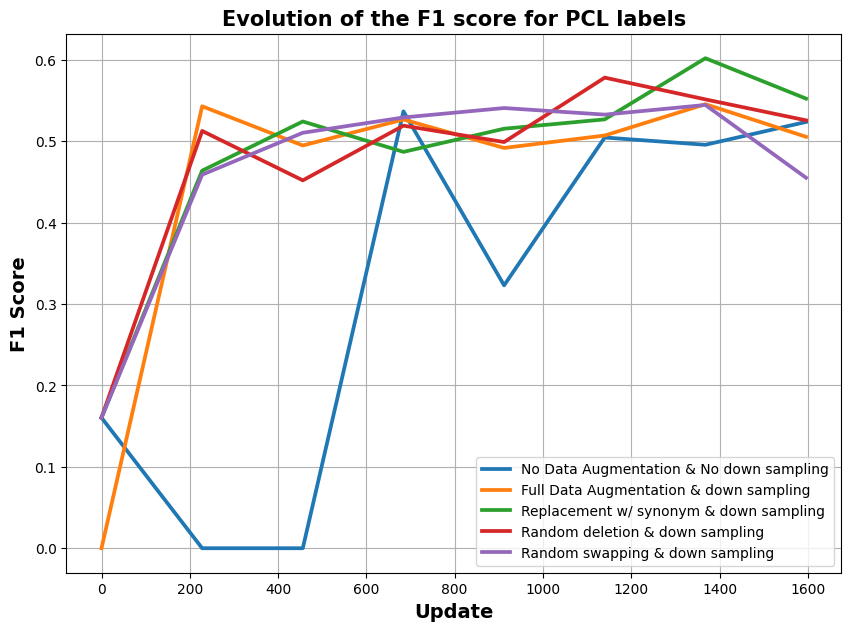

In [77]:
loaders_labels = ["No Data Augmentation & No down sampling", 
           "Full Data Augmentation & down sampling",  
           "Replacement w/ synonym & down sampling", 
           "Random deletion & down sampling", 
           "Random swapping & down sampling"]

plt.figure(figsize=(10,7))
plt.title("Evolution of the F1 score for PCL labels", fontweight="bold", fontsize=15)

for idx, f1_scores in enumerate(val_f1_scoress):
    
    plt.plot(np.arange(0, number_of_gradient_descent+1, int(number_of_gradient_descent/(len(f1_scores)-1))), f1_scores, label=loaders_labels[idx], linewidth=2.7)
    plt.legend()
    
plt.xlabel("Update", fontsize=14, fontweight="bold")
plt.ylabel("F1 Score", fontsize=14, fontweight="bold")

plt.grid(True)
plt.show()

# Output predictions function

In [ ]:
def labels2file(preds, outf_path):
    with open(outf_path,'w') as outf:
        for pred in preds:
            outf.write(','.join([str(int(pred))])+'\n')
            
def valid_output(model, validation_loader, prediction = False):
    model.eval()
    f1_scores = []
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0

    if prediction:

        preds = []

        with torch.no_grad():
            for _, data in tqdm(enumerate(validation_loader, 0)):
                ids = data['ids'].to(DEVICE, dtype = torch.long)
                mask = data['mask'].to(DEVICE, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
                outputs = model(ids, mask, token_type_ids).squeeze()
                
                
                big_idx = torch.round(outputs.data, decimals=0)

                preds.extend(list(big_idx))
            
        return preds

    else:
    
        preds, targs = [], []

        
        with torch.no_grad():
            for _, data in tqdm(enumerate(validation_loader, 0)):
                ids = data['ids'].to(DEVICE, dtype = torch.long)
                mask = data['mask'].to(DEVICE, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
                targets = data['targets'].to(DEVICE, dtype = torch.long)
                outputs = model(ids, mask, token_type_ids).squeeze()                
                
                targets = targets.float()
                loss_fn = torch.nn.BCELoss()
                loss = loss_fn(outputs, targets)
                
                tr_loss += loss.item()
                big_idx = torch.round(outputs.data, decimals=0)            
                n_correct += calculate_accuracy(big_idx, targets)
                
                preds.extend(list(big_idx))
                targs.extend(list(targets))
                            
                nb_tr_steps += 1
                nb_tr_examples+=targets.size(0)
                
                if _%5000==0:
                    loss_step = tr_loss/nb_tr_steps
                    
                    accu_step = (n_correct*100)/nb_tr_examples    
                
        f1_scores.append(calculate_f1_score(np.array(torch.Tensor(preds).cpu()), np.array(torch.Tensor(targs).cpu())))
                
        epoch_loss = tr_loss/nb_tr_steps
        epoch_accu = (n_correct*100)/nb_tr_examples
        
        return epoch_accu, f1_scores[-1]

# Final training

In [88]:
#### INPUT BEST PARAMETERS

import gc
gc.collect()
torch.cuda.empty_cache()

loader = augmented_training_loader_1
lr = 1e-05
number_of_gradient_descent = 1200
number_of_epochs = int(number_of_gradient_descent // len(loader)) + 1

best_model, _, _ = train(dataset_loader=loader, number_of_epochs=number_of_epochs, lr=lr)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.16035145524437122


0it [00:00, ?it/s]

F1 validation: 0.41509433962264153


0it [00:00, ?it/s]

F1 validation: 0.555256064690027


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.5552699228791773


0it [00:00, ?it/s]

F1 validation: 0.5555555555555556


0it [00:00, ?it/s]

F1 validation: 0.5169712793733682


0it [00:00, ?it/s]

0it [00:00, ?it/s]

F1 validation: 0.5853658536585367


0it [00:00, ?it/s]

F1 validation: 0.5737265415549598


0it [00:00, ?it/s]

F1 validation: 0.517094017094017


## Compute predictions for the test set

In [89]:
dev_pred = valid_output(best_model, testing_loader, prediction = True)
output_path = "dev.txt"
labels2file(dev_pred, output_path)

0it [00:00, ?it/s]

## Compute predictions for real test set

In [90]:
test_pred = valid_output(best_model, real_testing_loader, prediction = True)
output_path = "test.txt"
labels2file(test_pred, output_path)

0it [00:00, ?it/s]